In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate, Embedding, Dot
from tensorflow.keras.layers import Activation, ReLU, LeakyReLU, PReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, AlphaDropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from functools import partial

import os

import warnings
warnings.filterwarnings('ignore')

# Data 준비

In [2]:
data = pd.read_csv('./dataset/merged_data.csv')
data.head()

,genres,id,original_language,overview,popularity,spoken_languages,title,vote_average,vote_count,score,cast,crew,keywords,movieId,rating
0,Animation Comedy Family,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,English,Toy Story,7.7,5415,7.545539,TomHanks TimAllen DonRickles JimVarney Wallace...,JohnLasseter,jealousy toy boy friendship friends rivalry bo...,1,3.888157
1,Adventure Fantasy Family,8844,en,When siblings Judy and Peter discover an encha...,17.015539,English Français,Jumanji,6.9,2413,6.704621,RobinWilliams JonathanHyde KirstenDunst Bradle...,JoeJohnston,board game disappearance based on children's b...,2,3.236953
2,Action Crime Drama Thriller,949,en,"Obsessive master thief, Neil McCauley leads a ...",17.924927,English Español,Heat,7.7,1886,7.310584,AlPacino RobertDeNiro ValKilmer JonVoight TomS...,MichaelMann,robbery detective bank obsession chase shootin...,6,3.841764
3,Adventure Action Thriller,710,en,James Bond must unmask the mysterious head of ...,14.686036,English Pусский Español,GoldenEye,6.6,1194,6.338302,PierceBrosnan SeanBean IzabellaScorupco FamkeJ...,MartinCampbell,cuba falsely accused secret identity computer ...,10,3.431841
4,Drama Crime,524,en,The life of the gambling paradise – Las Vegas ...,10.137389,English,Casino,7.8,1343,7.267167,RobertDeNiro SharonStone JoePesci JamesWoods D...,MartinScorsese,poker drug abuse 1970s overdose illegal prosti...,16,3.795511


In [3]:
data.shape

(2291, 15)

In [4]:
data.drop(['rating'], axis=1, inplace=True)

- 이미 ratings 파일과 merge되었기 때문에, 해당 열을 다시 삭제

In [5]:
data.tail()

,genres,id,original_language,overview,popularity,spoken_languages,title,vote_average,vote_count,score,cast,crew,keywords,movieId
2286,ScienceFiction Thriller,406990,en,In a world where families are limited to one c...,60.581223,English,What Happened to Monday,7.3,598,6.592786,NoomiRapace MarwanKenzari ChristianRubeck Glen...,TommyWirkola,chase false identity overpopulation investigat...,173925
2287,Action Thriller,341013,en,An undercover MI6 agent is sent to Berlin duri...,14.455104,svenska English Deutsch Pусский,Atomic Blonde,6.1,748,5.923143,CharlizeTheron JamesMcAvoy SofiaBoutella Eddie...,DavidLeitch,berlin spy undercover cold war double agent un...,173941
2288,Action Drama History Thriller War,374720,en,The miraculous evacuation of Allied soldiers f...,30.938854,English Français Deutsch,Dunkirk,7.5,2712,7.240418,FionnWhitehead TomGlynn-Carney JackLowden Harr...,ChristopherNolan,france beach world war ii evacuation german pi...,174055
2289,Action ScienceFiction Thriller Adventure,335988,en,"Autobots and Decepticons are at war, with huma...",39.186819,English,Transformers: The Last Knight,6.2,1440,6.065291,MarkWahlberg JoshDuhamel LauraHaddock AnthonyH...,MichaelBay,knight transformers,174585
2290,Action Western ScienceFiction Fantasy Horror,353491,en,"The last Gunslinger, Roland Deschain, has been...",50.903593,English,The Dark Tower,5.7,688,5.668409,IdrisElba MatthewMcConaughey TomTaylor Claudia...,NikolajArcel,gunslinger based on novel,175197


In [6]:
ratings = pd.read_csv('./dataset/ratings_small.csv')

- 훈련에 너무 오랜 시간이 걸려 small data 사용

In [7]:
ratings.drop('timestamp', axis=1, inplace=True)

In [8]:
data = pd.merge(data, ratings)
data.head()

,genres,id,original_language,overview,popularity,spoken_languages,title,vote_average,vote_count,score,cast,crew,keywords,movieId,userId,rating
0,Animation Comedy Family,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,English,Toy Story,7.7,5415,7.545539,TomHanks TimAllen DonRickles JimVarney Wallace...,JohnLasseter,jealousy toy boy friendship friends rivalry bo...,1,7,3.0
1,Animation Comedy Family,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,English,Toy Story,7.7,5415,7.545539,TomHanks TimAllen DonRickles JimVarney Wallace...,JohnLasseter,jealousy toy boy friendship friends rivalry bo...,1,9,4.0
2,Animation Comedy Family,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,English,Toy Story,7.7,5415,7.545539,TomHanks TimAllen DonRickles JimVarney Wallace...,JohnLasseter,jealousy toy boy friendship friends rivalry bo...,1,13,5.0
3,Animation Comedy Family,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,English,Toy Story,7.7,5415,7.545539,TomHanks TimAllen DonRickles JimVarney Wallace...,JohnLasseter,jealousy toy boy friendship friends rivalry bo...,1,15,2.0
4,Animation Comedy Family,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,English,Toy Story,7.7,5415,7.545539,TomHanks TimAllen DonRickles JimVarney Wallace...,JohnLasseter,jealousy toy boy friendship friends rivalry bo...,1,19,3.0


In [9]:
data.shape

(60180, 16)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60180 entries, 0 to 60179
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genres             60180 non-null  object 
 1   id                 60180 non-null  int64  
 2   original_language  60180 non-null  object 
 3   overview           60180 non-null  object 
 4   popularity         60180 non-null  float64
 5   spoken_languages   60177 non-null  object 
 6   title              60180 non-null  object 
 7   vote_average       60180 non-null  float64
 8   vote_count         60180 non-null  int64  
 9   score              60180 non-null  float64
 10  cast               60179 non-null  object 
 11  crew               60180 non-null  object 
 12  keywords           60088 non-null  object 
 13  movieId            60180 non-null  int64  
 14  userId             60180 non-null  int64  
 15  rating             60180 non-null  float64
dtypes: float64(4), int64(4

# 모델을 위한 data 준비

In [11]:
le = LabelEncoder()
data['id'] = le.fit_transform(data['id'])

In [12]:
# le = LabelEncoder()
# data['userId'] = le.fit_transform(data['userId'])

- 추천을 위해 영화 id를 reset 해줌

In [13]:
data.head()

,genres,id,original_language,overview,popularity,spoken_languages,title,vote_average,vote_count,score,cast,crew,keywords,movieId,userId,rating
0,Animation Comedy Family,361,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,English,Toy Story,7.7,5415,7.545539,TomHanks TimAllen DonRickles JimVarney Wallace...,JohnLasseter,jealousy toy boy friendship friends rivalry bo...,1,7,3.0
1,Animation Comedy Family,361,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,English,Toy Story,7.7,5415,7.545539,TomHanks TimAllen DonRickles JimVarney Wallace...,JohnLasseter,jealousy toy boy friendship friends rivalry bo...,1,9,4.0
2,Animation Comedy Family,361,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,English,Toy Story,7.7,5415,7.545539,TomHanks TimAllen DonRickles JimVarney Wallace...,JohnLasseter,jealousy toy boy friendship friends rivalry bo...,1,13,5.0
3,Animation Comedy Family,361,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,English,Toy Story,7.7,5415,7.545539,TomHanks TimAllen DonRickles JimVarney Wallace...,JohnLasseter,jealousy toy boy friendship friends rivalry bo...,1,15,2.0
4,Animation Comedy Family,361,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,English,Toy Story,7.7,5415,7.545539,TomHanks TimAllen DonRickles JimVarney Wallace...,JohnLasseter,jealousy toy boy friendship friends rivalry bo...,1,19,3.0


In [14]:
data.tail()

,genres,id,original_language,overview,popularity,spoken_languages,title,vote_average,vote_count,score,cast,crew,keywords,movieId,userId,rating
60175,Action Adventure,1909,en,"Tarzan, having acclimated to life in London, i...",45.382980,English,The Legend of Tarzan,5.5,2488,5.517575,AlexanderSkarsgård MargotRobbie ChristophWaltz...,DavidYates,africa feral child tarzan jungle animal attack,160563,15,1.0
60176,Action Adventure,1909,en,"Tarzan, having acclimated to life in London, i...",45.382980,English,The Legend of Tarzan,5.5,2488,5.517575,AlexanderSkarsgård MargotRobbie ChristophWaltz...,DavidYates,africa feral child tarzan jungle animal attack,160563,287,4.0
60177,Action Horror Thriller,1981,en,Two years after choosing not to kill the man w...,13.178900,English,The Purge: Election Year,6.1,1356,5.983215,ElizabethMitchell FrankGrillo MykeltiWilliamso...,JamesDeMonaco,dystopia sequel legalized murder,160565,15,2.0
60178,Comedy,1980,en,"Mike and Dave are young, adventurous, fun-lovi...",12.237571,English,Mike and Dave Need Wedding Dates,5.9,901,5.808431,ZacEfron AdamDevine AnnaKendrick AubreyPlaza S...,JakeSzymanski,hawaii wedding wedding date,160567,15,4.0
60179,Family Animation,1998,en,A mother bird tries to teach her little one ho...,11.243161,English,Piper,8.2,487,6.983447,NaN,AlanBarillaro,bird fear short,160718,547,4.0


In [15]:
data[data['id'] == 0]

,genres,id,original_language,overview,popularity,spoken_languages,title,vote_average,vote_count,score,cast,crew,keywords,movieId,userId,rating
668,Crime Comedy,0,en,It's Ted the Bellhop's first night on the job....,9.026586,English,Four Rooms,6.5,539,6.106737,TimRoth AntonioBanderas JenniferBeals Madonna ...,AllisonAnders AlexandreRockwell RobertRodrigue...,hotel new year's eve witch bet hotel room sper...,18,18,3.0
669,Crime Comedy,0,en,It's Ted the Bellhop's first night on the job....,9.026586,English,Four Rooms,6.5,539,6.106737,TimRoth AntonioBanderas JenniferBeals Madonna ...,AllisonAnders AlexandreRockwell RobertRodrigue...,hotel new year's eve witch bet hotel room sper...,18,30,2.0
670,Crime Comedy,0,en,It's Ted the Bellhop's first night on the job....,9.026586,English,Four Rooms,6.5,539,6.106737,TimRoth AntonioBanderas JenniferBeals Madonna ...,AllisonAnders AlexandreRockwell RobertRodrigue...,hotel new year's eve witch bet hotel room sper...,18,36,4.0
671,Crime Comedy,0,en,It's Ted the Bellhop's first night on the job....,9.026586,English,Four Rooms,6.5,539,6.106737,TimRoth AntonioBanderas JenniferBeals Madonna ...,AllisonAnders AlexandreRockwell RobertRodrigue...,hotel new year's eve witch bet hotel room sper...,18,67,4.0
672,Crime Comedy,0,en,It's Ted the Bellhop's first night on the job....,9.026586,English,Four Rooms,6.5,539,6.106737,TimRoth AntonioBanderas JenniferBeals Madonna ...,AllisonAnders AlexandreRockwell RobertRodrigue...,hotel new year's eve witch bet hotel room sper...,18,86,5.0
673,Crime Comedy,0,en,It's Ted the Bellhop's first night on the job....,9.026586,English,Four Rooms,6.5,539,6.106737,TimRoth AntonioBanderas JenniferBeals Madonna ...,AllisonAnders AlexandreRockwell RobertRodrigue...,hotel new year's eve witch bet hotel room sper...,18,111,2.5
674,Crime Comedy,0,en,It's Ted the Bellhop's first night on the job....,9.026586,English,Four Rooms,6.5,539,6.106737,TimRoth AntonioBanderas JenniferBeals Madonna ...,AllisonAnders AlexandreRockwell RobertRodrigue...,hotel new year's eve witch bet hotel room sper...,18,112,3.0
675,Crime Comedy,0,en,It's Ted the Bellhop's first night on the job....,9.026586,English,Four Rooms,6.5,539,6.106737,TimRoth AntonioBanderas JenniferBeals Madonna ...,AllisonAnders AlexandreRockwell RobertRodrigue...,hotel new year's eve witch bet hotel room sper...,18,135,4.0
676,Crime Comedy,0,en,It's Ted the Bellhop's first night on the job....,9.026586,English,Four Rooms,6.5,539,6.106737,TimRoth AntonioBanderas JenniferBeals Madonna ...,AllisonAnders AlexandreRockwell RobertRodrigue...,hotel new year's eve witch bet hotel room sper...,18,154,5.0
677,Crime Comedy,0,en,It's Ted the Bellhop's first night on the job....,9.026586,English,Four Rooms,6.5,539,6.106737,TimRoth AntonioBanderas JenniferBeals Madonna ...,AllisonAnders AlexandreRockwell RobertRodrigue...,hotel new year's eve witch bet hotel room sper...,18,177,4.0


In [16]:
data[data['userId'] == 330]

,genres,id,original_language,overview,popularity,spoken_languages,title,vote_average,vote_count,score,cast,crew,keywords,movieId,userId,rating
626,Drama Crime,198,en,The life of the gambling paradise – Las Vegas ...,10.137389,English,Casino,7.8,1343,7.267167,RobertDeNiro SharonStone JoePesci JamesWoods D...,MartinScorsese,poker drug abuse 1970s overdose illegal prosti...,16,330,3.0
876,ScienceFiction Thriller Mystery,19,en,"In the year 2035, convict James Cole reluctant...",12.297305,English Français,Twelve Monkeys,7.4,2470,7.133731,BruceWillis MadeleineStowe BradPitt Christophe...,TerryGilliam,schizophrenia philadelphia cassandra syndrom s...,32,330,4.0
1644,Drama Crime Thriller,254,en,"Held in an L.A. interrogation room, Verbal Kin...",16.302466,Español English Français Magyar,The Usual Suspects,8.1,3334,7.814160,StephenBaldwin GabrielByrne ChazzPalminteri Ke...,BryanSinger,law relatives theft criminal criminal mastermi...,50,330,4.0
2133,Action Drama History War,93,en,"Enraged at the slaughter of Murron, his new br...",20.755149,English Français Latin,Braveheart,7.7,3404,7.464605,MelGibson CatherineMcCormack SophieMarceau Pat...,MelGibson,individual scotland in love with enemy legend ...,110,330,4.0
2517,Drama,216,en,The true story of technical troubles that scut...,18.761467,English,Apollo 13,7.3,1637,6.947588,TomHanks BillPaxton KevinBacon GarySinise EdHa...,RonHoward,moon florida nasa spaceman race against time h...,150,330,2.0
3023,Action Thriller,461,en,New York detective John McClane is back and ki...,15.138855,English Deutsch Română,Die Hard: With a Vengeance,6.9,2094,6.679966,BruceWillis JeremyIrons SamuelL.Jackson Graham...,JohnMcTiernan,bomb taxi riddle robbery detective helicopter ...,165,330,2.0
3588,Comedy,802,en,Lloyd and Harry are two men whose stupidity is...,9.844558,English,Dumb and Dumber,6.5,1894,6.335634,JimCarrey JeffDaniels LaurenHolly TeriGarr Mik...,PeterFarrelly BobbyFarrelly,gas station motel utah stupidity pill prank ci...,231,330,2.0
4504,Thriller Crime Drama,45,fr,"Leon, the top hit man in New York, has earned ...",20.477329,English,Leon: The Professional,8.2,4293,7.962969,JeanReno NataliePortman GaryOldman DannyAiello...,LucBesson,new york corruption assassin police brutality ...,293,330,5.0
5263,Drama Crime,121,en,Framed in the 1940s for the double murder of h...,51.645403,English,The Shawshank Redemption,8.5,8358,8.357752,TimRobbins MorganFreeman BobGunton ClancyBrown...,FrankDarabont,prison corruption police brutality prison cell...,318,330,4.0
5580,Romance Drama,473,en,Gilbert has to care for his brother Arnie and ...,10.391900,English,What's Eating Gilbert Grape,7.5,943,6.906939,JohnnyDepp LeonardoDiCaprio JulietteLewis Darl...,LasseHallström,brother brother relationship mentally disabled...,337,330,3.0


In [17]:
train, test = train_test_split(data, test_size=0.2, random_state=30)

In [18]:
number_of_unique_user = data.userId.max() + 1
number_of_unique_movie_id = len(data.id.unique())
print(number_of_unique_user, number_of_unique_movie_id)

672 1999


- user id는 순차적으로 numbering되지 않았기 때문에 max값을 사용, 또한 id가 1부터 시작하므로 +1을 해줌

# Dot을 이용한 모델

간단한 Dot product 형태의 모델이다.   
사용자 embedding과 영화 embedding을 기반으로 나온 벡터 값을 Dot 연산을 통해 rating을 예측하는 방법

In [19]:
# layer 만들기
movie_input = Input(shape=(1,), name='movie_input_layer')
user_input = Input(shape=(1,), name='user_input_layer')

movie_embedding_layer = Embedding(number_of_unique_movie_id, 8, input_length=1, name='movie_embedding_layer')
user_embedding_layer = Embedding(number_of_unique_user, 8, input_length=1, name='user_embedding_layer')

movie_vector_layer = Flatten(name='movie_vector_layer')
user_vector_layer = Flatten(name='user_vector_layer')

dot_result_layer = Dot(name='dot_vector_layer', axes=1)

In [20]:
# 쌓기
movie_embedding = movie_embedding_layer(movie_input)
user_embedding = user_embedding_layer(user_input)

movie_vector = movie_vector_layer(movie_embedding)
user_vector = user_vector_layer(user_embedding)

dot_result = dot_result_layer([movie_vector, user_vector])
model = Model(inputs=[movie_input, user_input], outputs=dot_result)


In [21]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_input_layer (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input_layer (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_embedding_layer (Embeddin (None, 1, 8)         15992       movie_input_layer[0][0]          
__________________________________________________________________________________________________
user_embedding_layer (Embedding (None, 1, 8)         5376        user_input_layer[0][0]           
_______________________________________________________________________________________

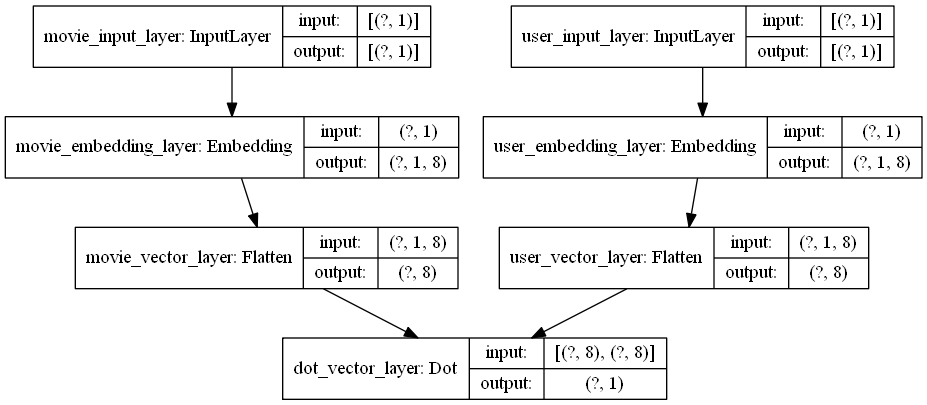

In [22]:
plot_model(model, to_file='dot_model.png', show_shapes=True, show_layer_names=True)

In [23]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [25]:
history = model.fit([train.id, train.userId], train.rating, validation_split=0.2, epochs=100, verbose=1,
                   callbacks=early_stopping)

Epoch 1/100
1204/1204 [==============================] - 3s 2ms/step - loss: 13.6928 - mse: 13.6928 - val_loss: 11.8772 - val_mse: 11.8772
Epoch 2/100
1204/1204 [==============================] - 4s 3ms/step - loss: 7.3563 - mse: 7.3563 - val_loss: 4.1668 - val_mse: 4.1668
Epoch 3/100
1204/1204 [==============================] - 4s 3ms/step - loss: 2.8345 - mse: 2.8345 - val_loss: 2.1918 - val_mse: 2.1918
Epoch 4/100
1204/1204 [==============================] - 4s 3ms/step - loss: 1.6750 - mse: 1.6750 - val_loss: 1.5156 - val_mse: 1.5156
Epoch 5/100
1204/1204 [==============================] - 4s 3ms/step - loss: 1.2205 - mse: 1.2205 - val_loss: 1.2062 - val_mse: 1.2062
Epoch 6/100
1204/1204 [==============================] - 4s 3ms/step - loss: 1.0039 - mse: 1.0039 - val_loss: 1.0484 - val_mse: 1.0484
Epoch 7/100
1204/1204 [==============================] - 4s 3ms/step - loss: 0.8890 - mse: 0.8890 - val_loss: 0.9601 - val_mse: 0.9601
Epoch 8/100
1204/1204 [============================

Text(0, 0.5, 'training error')

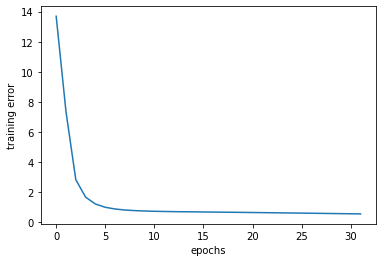

In [26]:
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('training error')

In [27]:
model.evaluate([test.id, test.userId], test.rating)

377/377 [==============================] - 1s 1ms/step - loss: 0.8234 - mse: 0.8234


[0.8234220147132874, 0.8234220147132874]

In [28]:
predictions = model.predict([test.id.head(10), test.userId.head(10)])

for p, t in zip(predictions, test.rating.values[:10]):
    print(p, t)

[2.917981] 3.0
[3.6704617] 4.0
[3.8742523] 4.0
[3.6060839] 3.5
[4.5757575] 5.0
[3.2080047] 2.0
[3.791625] 4.0
[3.5726578] 3.0
[3.8203795] 5.0
[3.575158] 3.5


# Neural Network로 만들기
위에서는 단순하게 Dot을 이용해서 rating을 예측하는 형태로 만들었다.   
이번에는 Dense layer를 이용해서 layer를 쌓고 rating을 예측하는 방법을 적용해본다.

In [29]:
# layer 쌓기
movie_input = Input(shape=(1, ), name='movie_input_layer')
user_input = Input(shape=(1, ), name='user_input_layer')

movie_embedding_layer = Embedding(number_of_unique_movie_id, 8, input_length=1, name='movie_embedding_layer')
user_embedding_layer = Embedding(number_of_unique_user, 8, input_length=1, name='user_embedding_layer')

movie_vector_layer = Flatten(name='movie_vector_layer')
user_vector_layer = Flatten(name='user_vector_layer')

dense_layer1 = Dense(128, activation='relu')
dense_layer2 = Dense(32, activation='relu')

result_layer = Dense(1)

In [30]:
# 쌓기
movie_embedding = movie_embedding_layer(movie_input)
user_embedding = user_embedding_layer(user_input)

movie_vector = movie_vector_layer(movie_embedding)
user_vector = user_vector_layer(user_embedding)

concat = concatenate([movie_vector, user_vector])

dense1 = dense_layer1(concat)
dense2 = dense_layer2(dense1)

result = result_layer(dense2)

model = Model(inputs=[movie_input, user_input], outputs=result)

In [31]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_input_layer (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input_layer (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_embedding_layer (Embeddin (None, 1, 8)         15992       movie_input_layer[0][0]          
__________________________________________________________________________________________________
user_embedding_layer (Embedding (None, 1, 8)         5376        user_input_layer[0][0]           
_______________________________________________________________________________________

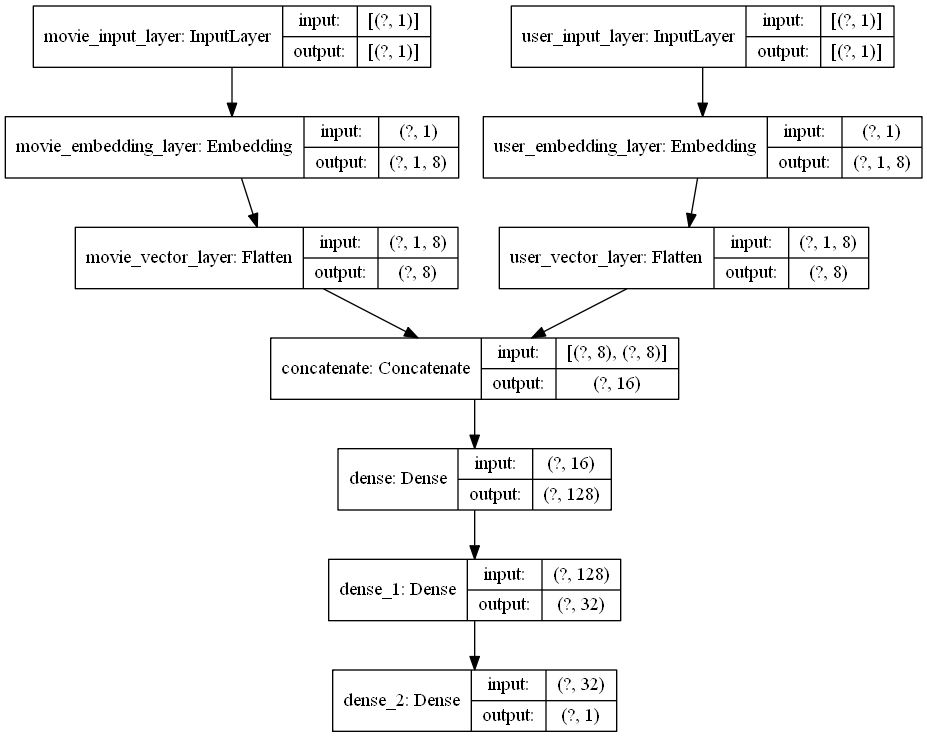

In [32]:
plot_model(model, to_file='nn_model.png', show_shapes=True, show_layer_names=True)

In [33]:
model.compile(loss = 'mse', optimizer='adam', metrics=['mse'])

In [34]:
history = model.fit([train.id, train.userId], train.rating, validation_split=0.2, epochs=100, verbose=1,
                   callbacks=early_stopping)

Epoch 1/100
1204/1204 [==============================] - 3s 3ms/step - loss: 1.2271 - mse: 1.2271 - val_loss: 0.7742 - val_mse: 0.7742
Epoch 2/100
1204/1204 [==============================] - 5s 4ms/step - loss: 0.7370 - mse: 0.7370 - val_loss: 0.7554 - val_mse: 0.7554
Epoch 3/100
1204/1204 [==============================] - 5s 4ms/step - loss: 0.7014 - mse: 0.7014 - val_loss: 0.7417 - val_mse: 0.7417
Epoch 4/100
1204/1204 [==============================] - 5s 4ms/step - loss: 0.6794 - mse: 0.6794 - val_loss: 0.7427 - val_mse: 0.7427
Epoch 5/100
1204/1204 [==============================] - 5s 4ms/step - loss: 0.6610 - mse: 0.6610 - val_loss: 0.7387 - val_mse: 0.7387
Epoch 6/100
1204/1204 [==============================] - 5s 4ms/step - loss: 0.6445 - mse: 0.6445 - val_loss: 0.7544 - val_mse: 0.7544
Epoch 7/100
1204/1204 [==============================] - 4s 4ms/step - loss: 0.6245 - mse: 0.6245 - val_loss: 0.7497 - val_mse: 0.7497
Epoch 8/100
1204/1204 [==============================] 

Text(0, 0.5, 'training error')

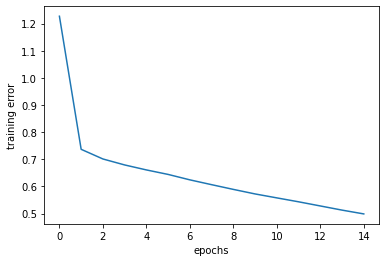

In [35]:
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('training error')

In [36]:
model.evaluate([test.id, test.userId], test.rating)

377/377 [==============================] - 1s 2ms/step - loss: 0.7435 - mse: 0.7435


[0.7434793710708618, 0.7434793710708618]

In [37]:
predictions = model.predict([test.id.head(10), test.userId.head(10)])

for p, t in zip(predictions, test.rating.values[:10]):
    print(p, t)

[2.8880048] 3.0
[3.451883] 4.0
[3.7686825] 4.0
[3.015404] 3.5
[4.4046755] 5.0
[2.7873516] 2.0
[3.5173972] 4.0
[3.6051395] 3.0
[3.8513846] 5.0
[3.389431] 3.5


# 추천하기

In [38]:
tmp_movie_data = np.arange(0, number_of_unique_movie_id)
tmp_user = np.array([330 for i in range(number_of_unique_movie_id)])

In [39]:
print(tmp_movie_data[:10])
print(tmp_user[:10])

[0 1 2 3 4 5 6 7 8 9]
[330 330 330 330 330 330 330 330 330 330]


In [40]:
predictions = model.predict([tmp_movie_data, tmp_user])
predictions = np.array([p[0] for p in predictions])
print(predictions[:5])

[3.0021791 3.4687228 3.2165155 3.3162835 3.4477935]


In [41]:
recommended_movie_ids = (-predictions).argsort()[:10]
print(recommended_movie_ids)

[ 121  105  798 1675 1919 1295 1205  215  398  254]


In [42]:
predictions[recommended_movie_ids]

array([3.9104242, 3.878049 , 3.8403516, 3.836505 , 3.8217063, 3.8091922,
       3.8069346, 3.7807877, 3.7762442, 3.770001 ], dtype=float32)

In [43]:
sorted(predictions, reverse=True)[:10]

[3.9104242,
 3.878049,
 3.8403516,
 3.836505,
 3.8217063,
 3.8091922,
 3.8069346,
 3.7807877,
 3.7762442,
 3.770001]

In [44]:
recommend = data[data['id'].isin(recommended_movie_ids)]
recommend

,genres,id,original_language,overview,popularity,spoken_languages,title,vote_average,vote_count,score,cast,crew,keywords,movieId,userId,rating
1550,Drama Crime Thriller,254,en,"Held in an L.A. interrogation room, Verbal Kin...",16.302466,Español English Français Magyar,The Usual Suspects,8.1,3334,7.814160,StephenBaldwin GabrielByrne ChazzPalminteri Ke...,BryanSinger,law relatives theft criminal criminal mastermi...,50,2,4.0
1551,Drama Crime Thriller,254,en,"Held in an L.A. interrogation room, Verbal Kin...",16.302466,Español English Français Magyar,The Usual Suspects,8.1,3334,7.814160,StephenBaldwin GabrielByrne ChazzPalminteri Ke...,BryanSinger,law relatives theft criminal criminal mastermi...,50,8,5.0
1552,Drama Crime Thriller,254,en,"Held in an L.A. interrogation room, Verbal Kin...",16.302466,Español English Français Magyar,The Usual Suspects,8.1,3334,7.814160,StephenBaldwin GabrielByrne ChazzPalminteri Ke...,BryanSinger,law relatives theft criminal criminal mastermi...,50,10,5.0
1553,Drama Crime Thriller,254,en,"Held in an L.A. interrogation room, Verbal Kin...",16.302466,Español English Français Magyar,The Usual Suspects,8.1,3334,7.814160,StephenBaldwin GabrielByrne ChazzPalminteri Ke...,BryanSinger,law relatives theft criminal criminal mastermi...,50,11,5.0
1554,Drama Crime Thriller,254,en,"Held in an L.A. interrogation room, Verbal Kin...",16.302466,Español English Français Magyar,The Usual Suspects,8.1,3334,7.814160,StephenBaldwin GabrielByrne ChazzPalminteri Ke...,BryanSinger,law relatives theft criminal criminal mastermi...,50,15,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58609,Drama Action,1675,en,A biographical drama centered on the rivalry b...,10.635520,English Deutsch Italiano Français,Rush,7.7,2310,7.370756,DanielBrühl ChrisHemsworth OliviaWilde Alexand...,RonHoward,world champion sport racing car automobile rac...,104913,563,4.5
58610,Drama Action,1675,en,A biographical drama centered on the rivalry b...,10.635520,English Deutsch Italiano Français,Rush,7.7,2310,7.370756,DanielBrühl ChrisHemsworth OliviaWilde Alexand...,RonHoward,world champion sport racing car automobile rac...,104913,572,4.5
59567,Drama Thriller Comedy,1919,es,Six short stories that explore the extremities...,8.764888,Español,Wild Tales,7.7,878,7.011399,RicardoDarín LeonardoSbaraglia DaríoGrandinett...,DamiánSzifrón,revenge wedding party road rage,116897,15,4.5
59568,Drama Thriller Comedy,1919,es,Six short stories that explore the extremities...,8.764888,Español,Wild Tales,7.7,878,7.011399,RicardoDarín LeonardoSbaraglia DaríoGrandinett...,DamiánSzifrón,revenge wedding party road rage,116897,378,4.5


In [45]:
grouped_re = recommend.groupby('id').mean()
grouped_re

,popularity,vote_average,vote_count,score,movieId,userId,rating
id,,,,,,,
105,41.109264,8.5,6024.0,8.306342,858.0,370.925000,4.487500
121,51.645403,8.5,8358.0,8.357752,318.0,340.948553,4.487138
215,17.911314,8.2,1531.0,7.629799,904.0,322.304348,4.315217
254,16.302466,8.1,3334.0,7.814160,50.0,340.328358,4.370647
398,5.782544,7.8,435.0,6.710420,913.0,328.403226,4.387097
798,6.138669,7.4,531.0,6.598710,9010.0,394.000000,5.000000
1205,7.274237,7.5,997.0,6.929319,61240.0,373.333333,3.777778
1295,12.753109,7.2,1626.0,6.866774,72641.0,348.736842,3.894737
1675,10.635520,7.7,2310.0,7.370756,104913.0,434.818182,4.363636


In [46]:
recommend = recommend.drop_duplicates('id')
recommend

,genres,id,original_language,overview,popularity,spoken_languages,title,vote_average,vote_count,score,cast,crew,keywords,movieId,userId,rating
1550,Drama Crime Thriller,254,en,"Held in an L.A. interrogation room, Verbal Kin...",16.302466,Español English Français Magyar,The Usual Suspects,8.1,3334,7.814160,StephenBaldwin GabrielByrne ChazzPalminteri Ke...,BryanSinger,law relatives theft criminal criminal mastermi...,50,2,4.0
5118,Drama Crime,121,en,Framed in the 1940s for the double murder of h...,51.645403,English,The Shawshank Redemption,8.5,8358,8.357752,TimRobbins MorganFreeman BobGunton ClancyBrown...,FrankDarabont,prison corruption police brutality prison cell...,318,3,5.0
13028,Drama Crime,105,en,"Spanning the years 1945 to 1955, a chronicle o...",41.109264,English Italiano Latin,The Godfather,8.5,6024,8.306342,MarlonBrando AlPacino JamesCaan RichardS.Caste...,FrancisFordCoppola,italy love at first sight loss of father patri...,858,4,5.0
13405,Drama Mystery Thriller,215,en,"Professional photographer L.B. ""Jeff"" Jeffries...",17.911314,English,Rear Window,8.2,1531,7.629799,JamesStewart GraceKelly WendellCorey ThelmaRit...,AlfredHitchcock,nurse photographer suspicion of murder girlfri...,904,15,5.0
13800,Mystery Crime Thriller,398,en,A private detective takes on a case that invol...,5.782544,English,The Maltese Falcon,7.8,435,6.710420,HumphreyBogart MaryAstor GladysGeorge PeterLor...,JohnHuston,san francisco detective loss of husband murder...,913,4,5.0
48995,Drama Comedy Romance,798,fr,"As adults, best friends Julien and Sophie cont...",6.138669,Français,Love Me If You Dare,7.4,531,6.598710,GuillaumeCanet MarionCotillard ThibaultVerhaeg...,YannSamuell,belgium test of courage crush,9010,165,5.0
54197,Horror Drama,1205,sv,"Set in 1982 in the suburb of Blackeberg, Stock...",7.274237,svenska,Let the Right One In,7.5,997,6.929319,KåreHedebrant LinaLeandersson PerRagnar Henrik...,TomasAlfredson,female nudity vampire castration bullying chil...,61240,48,4.5
55498,Drama,1295,en,"Oversized African-American, Michael Oher, the ...",12.753109,English,The Blind Side,7.2,1626,6.866774,SandraBullock QuintonAaron KathyBates TimMcGra...,JohnLeeHancock,american football adoption education private s...,72641,73,4.0
58600,Drama Action,1675,en,A biographical drama centered on the rivalry b...,10.635520,English Deutsch Italiano Français,Rush,7.7,2310,7.370756,DanielBrühl ChrisHemsworth OliviaWilde Alexand...,RonHoward,world champion sport racing car automobile rac...,104913,73,4.5
59567,Drama Thriller Comedy,1919,es,Six short stories that explore the extremities...,8.764888,Español,Wild Tales,7.7,878,7.011399,RicardoDarín LeonardoSbaraglia DaríoGrandinett...,DamiánSzifrón,revenge wedding party road rage,116897,15,4.5


In [47]:
for i in recommended_movie_ids :
    index = recommend[recommend['id'] == i].index
    recommend.loc[index, 'rating'] = grouped_re.loc[i, 'rating']

In [48]:
recommend

,genres,id,original_language,overview,popularity,spoken_languages,title,vote_average,vote_count,score,cast,crew,keywords,movieId,userId,rating
1550,Drama Crime Thriller,254,en,"Held in an L.A. interrogation room, Verbal Kin...",16.302466,Español English Français Magyar,The Usual Suspects,8.1,3334,7.814160,StephenBaldwin GabrielByrne ChazzPalminteri Ke...,BryanSinger,law relatives theft criminal criminal mastermi...,50,2,4.370647
5118,Drama Crime,121,en,Framed in the 1940s for the double murder of h...,51.645403,English,The Shawshank Redemption,8.5,8358,8.357752,TimRobbins MorganFreeman BobGunton ClancyBrown...,FrankDarabont,prison corruption police brutality prison cell...,318,3,4.487138
13028,Drama Crime,105,en,"Spanning the years 1945 to 1955, a chronicle o...",41.109264,English Italiano Latin,The Godfather,8.5,6024,8.306342,MarlonBrando AlPacino JamesCaan RichardS.Caste...,FrancisFordCoppola,italy love at first sight loss of father patri...,858,4,4.487500
13405,Drama Mystery Thriller,215,en,"Professional photographer L.B. ""Jeff"" Jeffries...",17.911314,English,Rear Window,8.2,1531,7.629799,JamesStewart GraceKelly WendellCorey ThelmaRit...,AlfredHitchcock,nurse photographer suspicion of murder girlfri...,904,15,4.315217
13800,Mystery Crime Thriller,398,en,A private detective takes on a case that invol...,5.782544,English,The Maltese Falcon,7.8,435,6.710420,HumphreyBogart MaryAstor GladysGeorge PeterLor...,JohnHuston,san francisco detective loss of husband murder...,913,4,4.387097
48995,Drama Comedy Romance,798,fr,"As adults, best friends Julien and Sophie cont...",6.138669,Français,Love Me If You Dare,7.4,531,6.598710,GuillaumeCanet MarionCotillard ThibaultVerhaeg...,YannSamuell,belgium test of courage crush,9010,165,5.000000
54197,Horror Drama,1205,sv,"Set in 1982 in the suburb of Blackeberg, Stock...",7.274237,svenska,Let the Right One In,7.5,997,6.929319,KåreHedebrant LinaLeandersson PerRagnar Henrik...,TomasAlfredson,female nudity vampire castration bullying chil...,61240,48,3.777778
55498,Drama,1295,en,"Oversized African-American, Michael Oher, the ...",12.753109,English,The Blind Side,7.2,1626,6.866774,SandraBullock QuintonAaron KathyBates TimMcGra...,JohnLeeHancock,american football adoption education private s...,72641,73,3.894737
58600,Drama Action,1675,en,A biographical drama centered on the rivalry b...,10.635520,English Deutsch Italiano Français,Rush,7.7,2310,7.370756,DanielBrühl ChrisHemsworth OliviaWilde Alexand...,RonHoward,world champion sport racing car automobile rac...,104913,73,4.363636
59567,Drama Thriller Comedy,1919,es,Six short stories that explore the extremities...,8.764888,Español,Wild Tales,7.7,878,7.011399,RicardoDarín LeonardoSbaraglia DaríoGrandinett...,DamiánSzifrón,revenge wedding party road rage,116897,15,4.666667


In [49]:
recommend.title

1550           The Usual Suspects
5118     The Shawshank Redemption
13028               The Godfather
13405                 Rear Window
13800          The Maltese Falcon
48995         Love Me If You Dare
54197        Let the Right One In
55498              The Blind Side
58600                        Rush
59567                  Wild Tales
Name: title, dtype: object